In [76]:
import pandas as pd
import numpy as np
import ast
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier

# 1. Data cleaning 

Purpose: tidy **product_info.csv** into an analysis-ready table.

Main steps: drop noisy columns `cols_to_drop`, remove rows missing `rating` or `ingredients`, normalize category hierarchy (fill secondary/tertiary), parse `highlights` and `ingredients` into lists and counts.

Outputs: **products_cleaned_base.csv**, **highlight_tag_counts.csv**, **ingredient_token_counts.csv**.

In [ ]:
# ----------------------------------------------------
# 1. Load our data
# ----------------------------------------------------

INPUT_PATH = "data/product_info.csv"
OUTPUT_CLEANED_PATH = "data/products_cleaned_base.csv"
OUTPUT_HIGHLIGHT_COUNTS = "data/highlight_tag_counts.csv"
OUTPUT_INGREDIENT_COUNTS = "data/ingredient_token_counts.csv"

df = pd.read_csv(INPUT_PATH)

# ----------------------------------------------------
# 2. Drop unwanted columns
# ----------------------------------------------------
cols_to_drop = [
    "size",
    "variation_type",
    "variation_value",
    "variation_desc",
    "value_price_usd",
    "sale_price_usd",
    "child_max_price",
    "child_min_price",
]

df = df.drop(columns=cols_to_drop, errors="ignore")

# ----------------------------------------------------
# 3. Drop rows with NaN in rating or ingredients
# ----------------------------------------------------
df = df[df["rating"].notna()]
df = df[df["ingredients"].notna()]

# ----------------------------------------------------
# 4. Clean category hierarchy: primary / secondary / tertiary
# ----------------------------------------------------

def fill_secondary(row):
    sec = row.get("secondary_category")
    if pd.isna(sec):
        prim = row.get("primary_category", "Unknown")
        return f"{prim} General"
    return sec

df["secondary_category"] = df.apply(fill_secondary, axis=1)

# Ttreat NaNs as "General"
if "tertiary_category" in df.columns:
    df["tertiary_category"] = df["tertiary_category"].fillna("General")

# ----------------------------------------------------
# 5. Parse 'highlights' column and prepare tag selection
# ----------------------------------------------------
def parse_list_string(x):
    """
    Safely parse a string that looks like a Python list, e.g.
    "['Vegan', 'Matte Finish']" -> ['Vegan', 'Matte Finish'].
    If NaN or parsing fails, return [].
    """
    if pd.isna(x):
        return []
    if isinstance(x, list):
        return x
    try:
        parsed = ast.literal_eval(x)
        if isinstance(parsed, list):
            return parsed
        else:
            return []
    except Exception:
        
        return []

# New column with parsed highlights as list
if "highlights" in df.columns:
    df["highlights_list"] = df["highlights"].apply(parse_list_string)
else:
    df["highlights_list"] = [[] for _ in range(len(df))]

# Count all highlight tags
all_highlight_tags = [
    tag.strip()
    for tags in df["highlights_list"]
    for tag in tags
    if isinstance(tag, str)
]

highlight_counter = Counter(all_highlight_tags)


highlight_counts_df = (
    pd.DataFrame(
        [{"tag": tag, "count": count} for tag, count in highlight_counter.most_common()]
    )
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)

highlight_counts_df.to_csv(OUTPUT_HIGHLIGHT_COUNTS, index=False)
print(f"Saved highlight tag counts to: {OUTPUT_HIGHLIGHT_COUNTS}")
print(highlight_counts_df.head(15))


df["n_highlights"] = df["highlights_list"].apply(len)

# ----------------------------------------------------
# 6. Parse 'ingredients' and data-driven refinement
# ----------------------------------------------------

df["ingredients_list"] = df["ingredients"].apply(parse_list_string)

# join list and lowercase
def ingredients_to_text(ing_list):
    if not isinstance(ing_list, list):
        return ""
    # join with commas for separation
    text = ", ".join([str(x) for x in ing_list])
    return text.lower()

df["ingredients_text"] = df["ingredients_list"].apply(ingredients_to_text)


ingredient_tokens = []

for text in df["ingredients_text"]:
    if not text:
        continue
   
    parts = text.split(",")
    for p in parts:
        token = p.strip()
        if token:
            ingredient_tokens.append(token)

ingredient_counter = Counter(ingredient_tokens)

# Choose top 200
TOP_N_INGREDIENTS = 200
top_ingredients = ingredient_counter.most_common(TOP_N_INGREDIENTS)

ingredient_counts_df = pd.DataFrame(
    [{"ingredient_token": ing, "count": cnt} for ing, cnt in top_ingredients]
).sort_values("count", ascending=False)

ingredient_counts_df.to_csv(OUTPUT_INGREDIENT_COUNTS, index=False)
print(f"Saved ingredient token counts to: {OUTPUT_INGREDIENT_COUNTS}")
print(ingredient_counts_df.head(15))

# ----------------------------------------------------
# 7. Save base cleaned dataset
# ----------------------------------------------------
df.to_csv(OUTPUT_CLEANED_PATH, index=False)
print(f"Saved cleaned dataset (with parsed highlights/ingredients) to: {OUTPUT_CLEANED_PATH}")


Saved highlight tag counts to: data/highlight_tag_counts.csv
                                  tag  count
0                               Vegan   2365
1                        Cruelty-Free   1574
2                    Clean at Sephora   1438
3                    Without Parabens   1282
4                   Good for: Dryness   1119
5                           Hydrating   1100
6   Good for: Dullness/Uneven Texture    856
7         Without Sulfates SLS & SLES    727
8                        Long-wearing    686
9             Clean + Planet Positive    658
10                     All Hair Types    632
11               Good for: Anti-Aging    585
12                    Hyaluronic Acid    560
13                 Without Phthalates    479
14                     Fragrance Free    477
Saved ingredient token counts to: data/ingredient_token_counts.csv
                ingredient_token  count
0                       glycerin   4087
1                 phenoxyethanol   3802
2                caprylyl glycol

In [2]:
df = pd.read_csv("data/products_cleaned_base.csv")
from collections import Counter
def parse_list_string(x):
    if pd.isna(x):
        return []
    if isinstance(x, list):
        return x
    try:
        parsed = ast.literal_eval(x)
        return parsed if isinstance(parsed, list) else []
    except Exception:
        return []

df["highlights_list"] = df["highlights"].apply(parse_list_string)

# Pick enough tags to cover ~80% of highlight mentions but keep the set manageable (~20-30 tags)
tag_counter = Counter(
    tag
    for tags in df["highlights_list"]
    for tag in tags
    if isinstance(tag, str) and tag.strip()
 )
total_mentions = sum(tag_counter.values()) or 1
coverage_target = 0.8
max_tags = 30
min_tags = 20
selected_tags = []
running_total = 0
for tag, count in tag_counter.most_common():
    running_total += count
    selected_tags.append(tag)
    if len(selected_tags) >= min_tags and (running_total / total_mentions) >= coverage_target:
        break
selected_tags = selected_tags[:max_tags]

print(f"Selected {len(selected_tags)} highlight tags covering {running_total / total_mentions:.1%} of mentions")

for tag in selected_tags:
    col_name = "tag_" + tag.lower().replace(" ", "_").replace("/", "_").replace(":", "").replace(",", "").replace("&", "and")
    df[col_name] = df["highlights_list"].apply(lambda tags: int(tag in tags))

df["n_highlights"] = df["highlights_list"].apply(len)

Selected 30 highlight tags covering 80.2% of mentions


In [3]:
def parse_list_string(x):
    if pd.isna(x):
        return []
    if isinstance(x, list):
        return x
    try:
        parsed = ast.literal_eval(x)
        return parsed if isinstance(parsed, list) else []
    except Exception:
        return []

df["ingredients_list"] = df["ingredients"].apply(parse_list_string)

def ingredients_to_text(ing_list):
    if not isinstance(ing_list, list):
        return ""
    return ", ".join([str(x) for x in ing_list]).lower()

df["ingredients_text"] = df["ingredients_list"].apply(ingredients_to_text)

isel = pd.read_csv("data/ingredient_features_selected.csv", sep=";")

group_to_tokens = {}
for _, row in isel.iterrows():
    group = row["group_name"]
    token = str(row["token"]).lower()
    group_to_tokens.setdefault(group, []).append(token)

for group_name, tokens in group_to_tokens.items():
    df[group_name] = df["ingredients_text"].apply(
        lambda txt: int(any(tok in txt for tok in tokens))
    )

df["n_ingredients"] = df["ingredients_text"].apply(
    lambda txt: len([p for p in txt.split(",") if p.strip()])
)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7322 entries, 0 to 7321
Data columns (total 72 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   product_id                            7322 non-null   object 
 1   product_name                          7322 non-null   object 
 2   brand_id                              7322 non-null   int64  
 3   brand_name                            7322 non-null   object 
 4   loves_count                           7322 non-null   int64  
 5   rating                                7322 non-null   float64
 6   reviews                               7322 non-null   float64
 7   ingredients                           7322 non-null   object 
 8   price_usd                             7322 non-null   float64
 9   limited_edition                       7322 non-null   int64  
 10  new                                   7322 non-null   int64  
 11  online_only      

In [4]:
df.to_csv("data/products_final.csv", index=False)

# 2. Exploratory Data Analysis
We kick off with a quick dataset sanity check before the deeper engagement diagnostics.

## 2.0 Basic overview

In [5]:
DATA_PATH = "data/products_final.csv" 
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
df.head()

Shape: (7322, 72)


,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,ingredients,price_usd,limited_edition,...,has_antioxidant_vitamins,has_niacinamide,has_caffeine,has_adenosine,has_barrier_soothing,has_chemical_sunscreen,has_mineral_sunscreen,has_common_preservatives,has_hair_conditioning_agents,n_ingredients
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,"['Capri Eau de Parfum:', 'Alcohol Denat. (SD A...",35.0,0,...,0,0,0,0,0,1,0,0,0,94
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",195.0,0,...,0,0,0,0,0,1,0,0,0,13
2,P473662,Rainbow Bar Eau de Parfum,6342,19-69,3253,4.2500,16.0,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",195.0,0,...,0,0,0,0,0,1,0,0,0,12
3,P473660,Kasbah Eau de Parfum,6342,19-69,3018,4.4762,21.0,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",195.0,0,...,0,0,0,0,0,1,0,0,0,12
4,P473658,Purple Haze Eau de Parfum,6342,19-69,2691,3.2308,13.0,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",195.0,0,...,0,0,0,0,0,1,0,0,0,12


## 2.1 Category coverage & spend signals
Understand which categories dominate volume and how price and engagement differ by segment.

In [6]:
product_id_col = "product_id" if "product_id" in df.columns else "product_name"
category_summary = (
    df.groupby("primary_category")
      .agg(
          products=(product_id_col, "nunique"),
          avg_price=("price_usd", "mean"),
          avg_loves=("loves_count", "mean"),
          avg_reviews=("reviews", "mean"),
          avg_rating=("rating", "mean"),
      )
      .sort_values("products", ascending=False)
      .head(10)
      .round(2)
)
category_summary

,products,avg_price,avg_loves,avg_reviews,avg_rating
primary_category,,,,,
Skincare,2224,58.40,28553.74,480.47,4.23
Makeup,1999,33.23,58668.89,747.16,4.14
Hair,1232,35.18,14892.55,276.18,4.22
Fragrance,1186,91.21,14494.89,292.70,4.25
Bath & Body,364,40.85,17803.96,210.18,4.19
Mini Size,257,20.51,28761.14,668.09,4.00
Men,58,32.97,4997.52,73.95,4.50
Tools & Brushes,2,25.00,6086.50,41.50,4.20


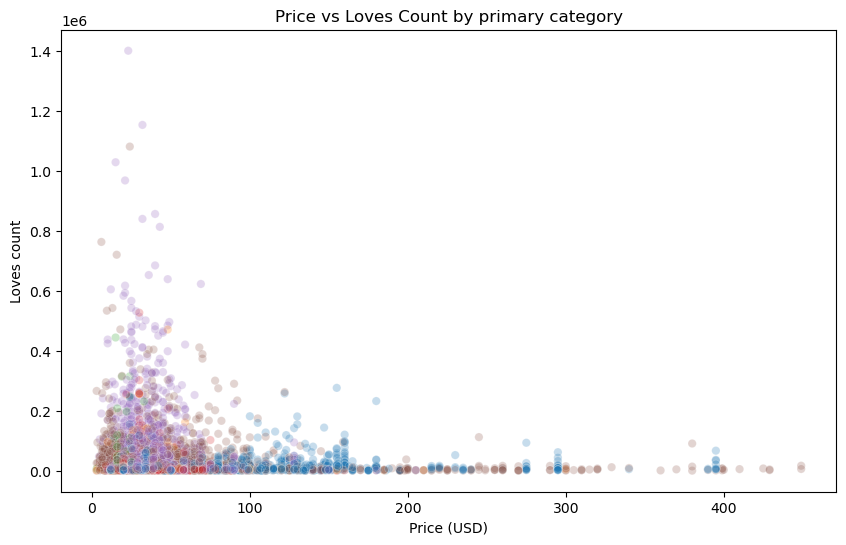

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x="price_usd",
    y="loves_count",
    hue="primary_category",
    alpha=0.25,
    legend=False
)
plt.title("Price vs Loves Count by primary category")
plt.xlabel("Price (USD)")
plt.ylabel("Loves count")
plt.show()

In [7]:
num_cols = ["price_usd", "loves_count", "rating", "reviews", "n_highlights", "n_ingredients"]
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
price_usd,7322.0,50.520610,47.669602,3.0,25.000000,35.00000,58.00000,449.0
loves_count,7322.0,31479.851543,68960.425831,0.0,4285.750000,10849.50000,29041.25000,1401068.0
rating,7322.0,4.199126,0.495827,1.0,3.995875,4.28885,4.52475,5.0
reviews,7322.0,478.301147,1125.133923,1.0,31.000000,144.00000,453.00000,21281.0
n_highlights,7322.0,3.749659,2.407591,0.0,2.000000,5.00000,6.00000,9.0
n_ingredients,7322.0,35.048211,34.133443,1.0,19.000000,28.00000,40.00000,720.0


## 2.2 Engagement snapshot
This section connects Sephora's business signals (price, engagement, satisfaction) before we derive the popularity label. We quantify central tendencies, highlight skew/outliers, and examine how price tiers relate to customer response.

Boxplots for numerical variables: 
- `price_usd`: The price of the product in US dollars
- `rating`: The average rating of the product based on user reviews
- `loves_count`: The number of people who have marked this product as a favorite

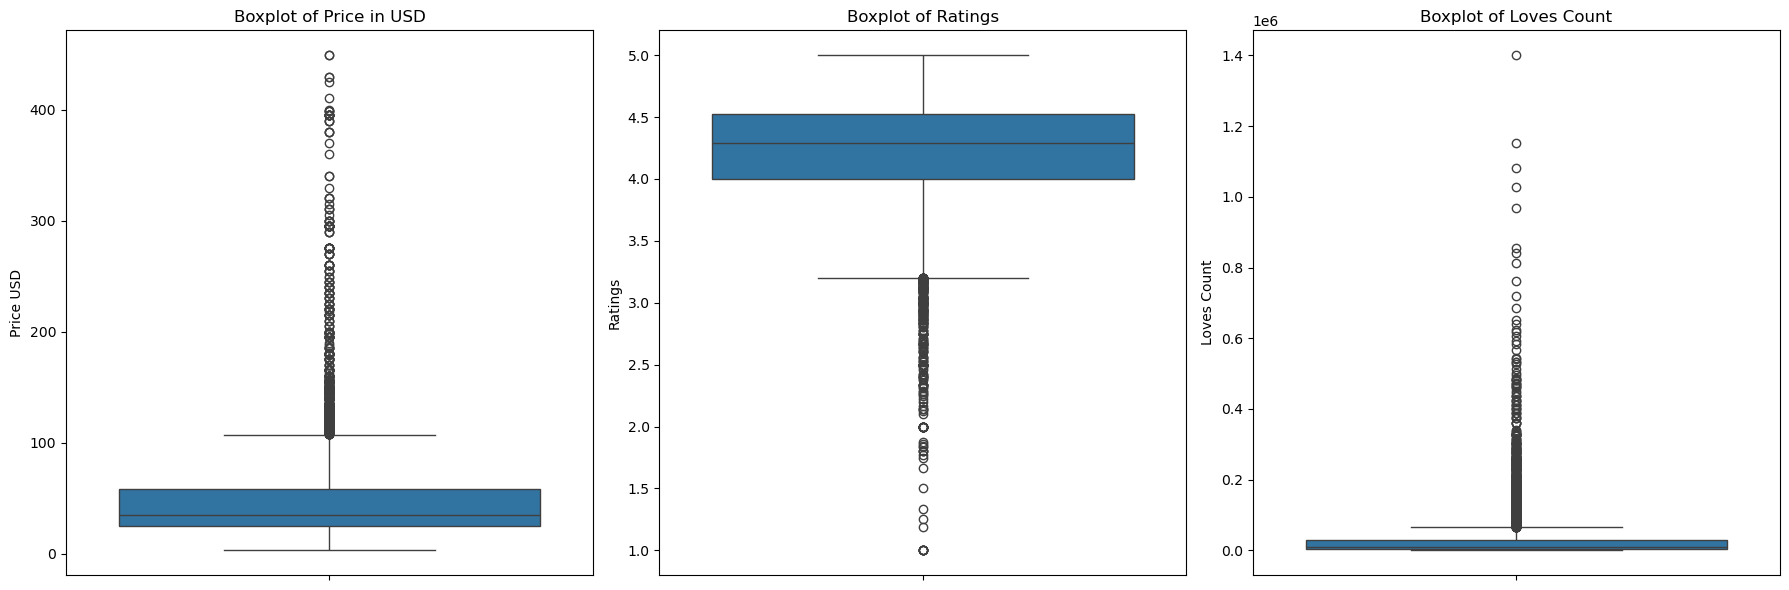

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Boxplot for 'price_usd'
sns.boxplot(y=df['price_usd'], ax=axes[0])
axes[0].set_title('Boxplot of Price in USD')
axes[0].set_ylabel('Price USD')

# Boxplot for 'rating'
sns.boxplot(y=df['rating'], ax=axes[1])
axes[1].set_title('Boxplot of Ratings')
axes[1].set_ylabel('Ratings')

# Boxplot for 'loves_count'
sns.boxplot(y=df['loves_count'], ax=axes[2])
axes[2].set_title('Boxplot of Loves Count')
axes[2].set_ylabel('Loves Count')

# Display the plots
plt.tight_layout()
plt.show()


Top 10 brands that have the biggest amount of products: 

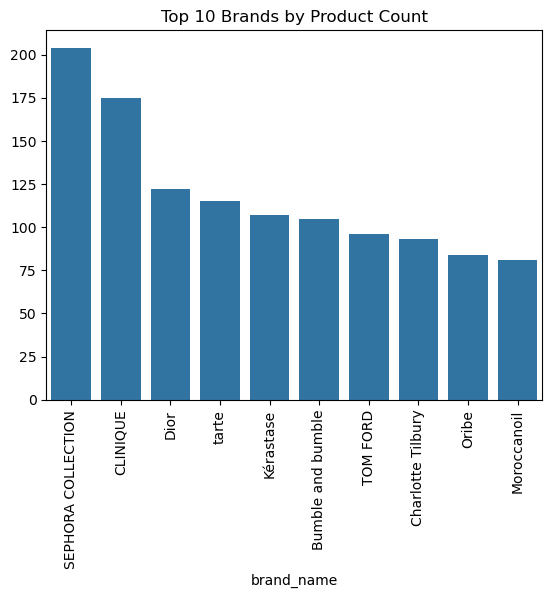

In [9]:
brand_count = df['brand_name'].value_counts().nlargest(10)
sns.barplot(x=brand_count.index, y=brand_count.values)
plt.title('Top 10 Brands by Product Count')
plt.xticks(rotation=90)
plt.show()

Distribution of the price, ratings, and loves count across all products

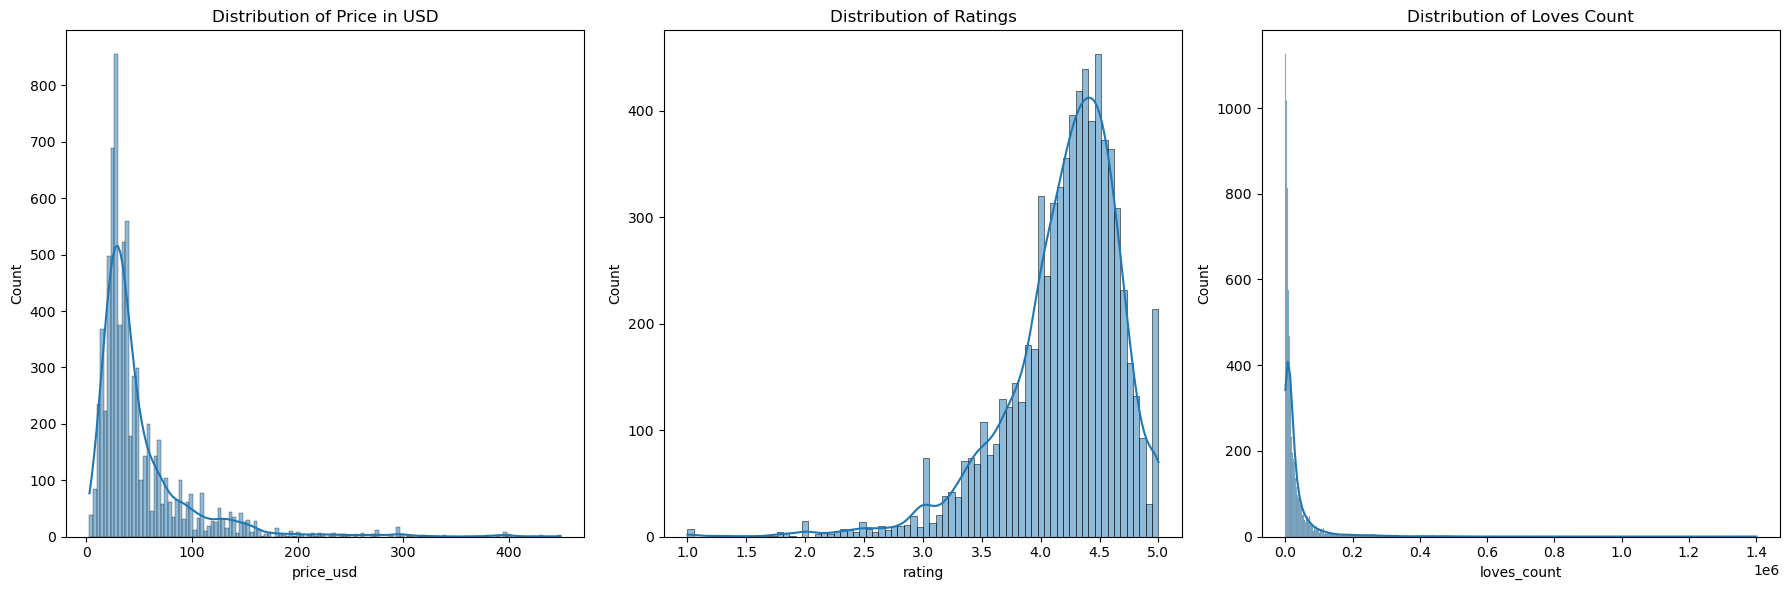

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Price histogram
sns.histplot(df['price_usd'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Price in USD')

# Rating histogram
sns.histplot(df['rating'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Ratings')

# Loves count histogram
sns.histplot(df['loves_count'], kde=True, ax=axes[2])
axes[2].set_title('Distribution of Loves Count')

plt.tight_layout()
plt.show()

Prive vs rating sactterplot

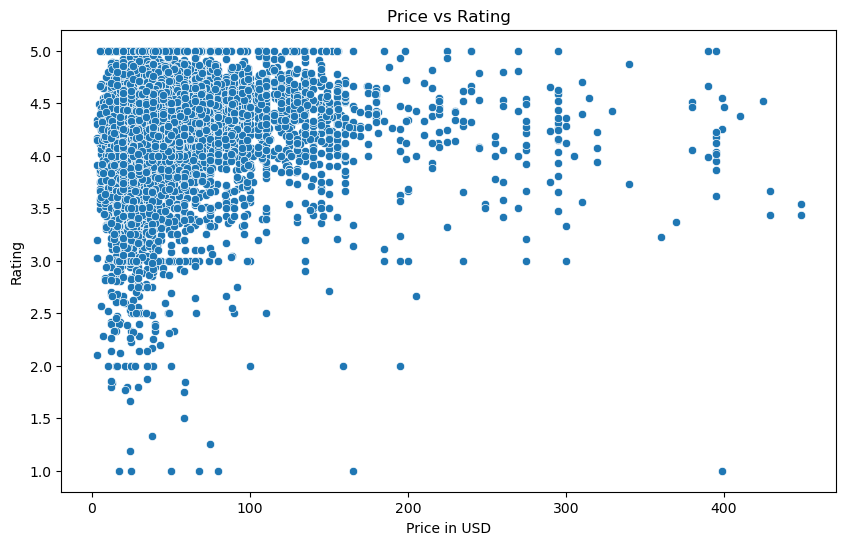

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='price_usd', y='rating', data=df)
plt.title('Price vs Rating')
plt.xlabel('Price in USD')
plt.ylabel('Rating')
plt.show()

### Price tiers vs engagement
Segment products into spend tiers to see if premium positioning correlates with customer actions.

In [12]:
price_labels = ["Budget", "Mass", "Prestige", "Luxury"]
price_bins = pd.qcut(df["price_usd"], q=[0, 0.25, 0.5, 0.75, 1], duplicates="drop")
if price_bins.dtype == "O" or len(price_bins.cat.categories) < len(price_labels):
    price_labels = price_labels[:len(price_bins.cat.categories)]
price_segment_col = price_bins.cat.rename_categories(price_labels)

df["price_segment"] = price_segment_col
price_segment_summary = (
    df.groupby("price_segment")
    .agg(
        products=("product_name", "count"),
        avg_loves=("loves_count", "mean"),
        avg_reviews=("reviews", "mean"),
        avg_rating=("rating", "mean"),
        median_price=("price_usd", "median")
    )
    .round(2)
)
price_segment_summary

C:\Users\User\AppData\Local\Temp\ipykernel_9348\2442587172.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("price_segment")


,products,avg_loves,avg_reviews,avg_rating,median_price
price_segment,,,,,
Budget,1909,38585.40,533.07,4.07,20.0
Mass,1811,32618.54,495.94,4.19,30.0
Prestige,1826,34828.56,533.15,4.25,44.0
Luxury,1776,19238.08,345.05,4.29,90.0


/var/folders/y7/21v74h5j5sn_fgcc5fd21wth0000gn/T/ipykernel_8389/2190911253.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="price_segment", y="rating", order=price_labels[:len(df["price_segment"].unique())], palette="pastel", cut=0)


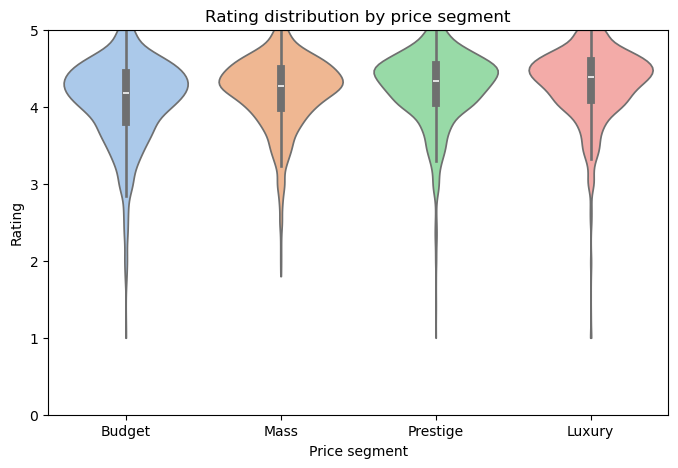

In [ ]:
plt.figure(figsize=(8, 5))
sns.violinplot(data=df, x="price_segment", y="rating", order=price_labels[:len(df["price_segment"].unique())], palette="pastel", cut=0)
plt.title("Rating distribution by price segment")
plt.xlabel("Price segment")
plt.ylabel("Rating")
plt.ylim(0, 5)
plt.show()

## 2.3 Engagement correlations
Quantify how the main behavioral signals align with one another before defining the final business target.

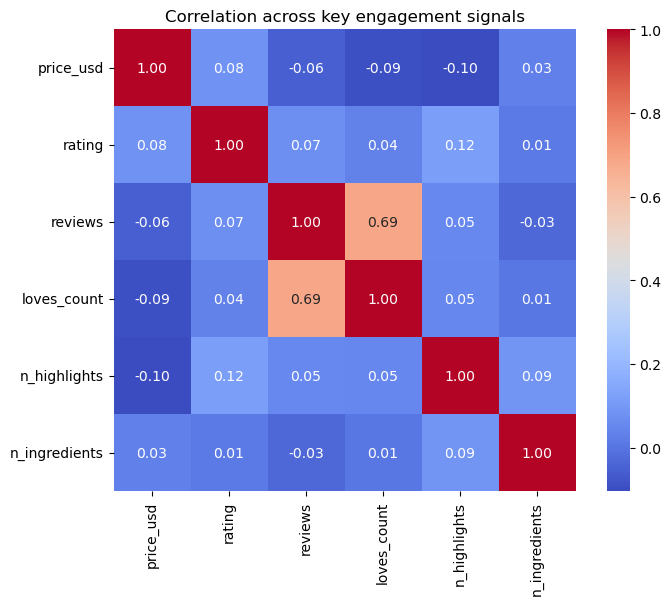

,price_usd,rating,reviews,loves_count,n_highlights,n_ingredients
price_usd,1.000000,0.079010,-0.056744,-0.092535,-0.104400,0.029547
rating,0.079010,1.000000,0.071651,0.037934,0.117010,0.014859
reviews,-0.056744,0.071651,1.000000,0.685993,0.053494,-0.034619
loves_count,-0.092535,0.037934,0.685993,1.000000,0.047820,0.005437
n_highlights,-0.104400,0.117010,0.053494,0.047820,1.000000,0.088142
n_ingredients,0.029547,0.014859,-0.034619,0.005437,0.088142,1.000000


In [13]:
engagement_cols = [
    "price_usd",
    "rating",
    "reviews",
    "loves_count",
    "n_highlights",
    "n_ingredients"
]
existing_cols = [c for c in engagement_cols if c in df.columns]
corr = df[existing_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation across key engagement signals")
plt.show()

corr

## 2.4 Feature engineering hooks
Create reusable metrics that will later help define the engagement target and power the ML models.

In [14]:
df["log_loves"] = np.log1p(df["loves_count"])
df["log_reviews"] = np.log1p(df["reviews"])
df["reviews_per_love"] = df["reviews"] / (df["loves_count"] + 1)
df["price_bucket"] = pd.qcut(df["price_usd"], q=[0, 0.25, 0.5, 0.75, 1], duplicates="drop")

feature_preview = df[["price_usd", "price_bucket", "log_loves", "log_reviews", "reviews_per_love"]].head()
feature_preview

,price_usd,price_bucket,log_loves,log_reviews,reviews_per_love
0,35.0,"(25.0, 35.0]",8.751633,2.484907,0.001740
1,195.0,"(58.0, 449.0]",8.250098,2.639057,0.003396
2,195.0,"(58.0, 449.0]",8.087640,2.833213,0.004917
3,195.0,"(58.0, 449.0]",8.012681,3.091042,0.006956
4,195.0,"(58.0, 449.0]",7.898040,2.639057,0.004829


## 2.5 Additional Feature Distributions

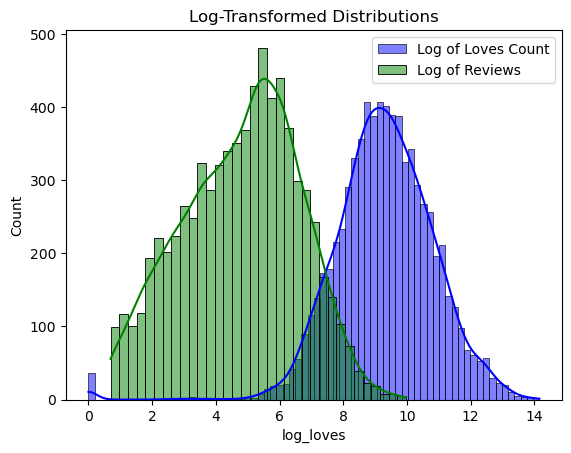

In [15]:
sns.histplot(df['log_loves'], kde=True, color='blue', label='Log of Loves Count')
sns.histplot(df['log_reviews'], kde=True, color='green', label='Log of Reviews')
plt.legend()
plt.title('Log-Transformed Distributions')
plt.show()

## 2.6 Missing data value analysis

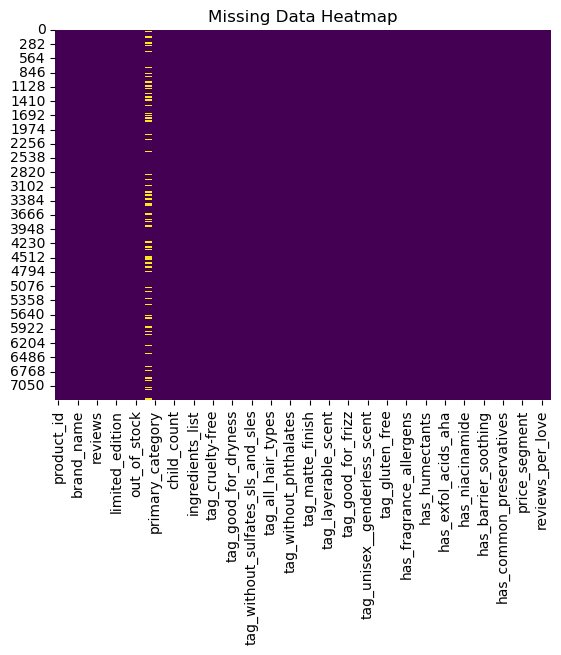

In [16]:
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()


# 3. Popularity Score 

First we need to do some scaling for the rating , as some products might have a super small amount of reviews and still have a rating of 5 

In [17]:
df['scaled_rating'] = df['rating'] * (df['reviews'] / df['reviews'].max())

Now we define the popularity score as a normalized blend of the three engagement signals (`loves_count`, review-adjusted rating, and `reviews`). Rather than hand-picking weights, we let the data drive the importance: features with higher variability (after scaling) get slightly more influence because they help discriminate products.

In [18]:
engagement_cols = ["loves_count", "scaled_rating", "reviews"]
scaler = MinMaxScaler()
norm_col_names = [f"{col}_norm" for col in engagement_cols]
df[norm_col_names] = scaler.fit_transform(df[engagement_cols])

feature_stds = df[norm_col_names].std()
feature_weights = (feature_stds / feature_stds.sum()).to_dict()
feature_weights

{'loves_count_norm': 0.3132990964484382,
 'scaled_rating_norm': 0.35014980141603147,
 'reviews_norm': 0.3365511021355304}

Also, we will apply Min-Max scaling to each individual feature before combining them into the popularity score. This way, the popularity score will naturally be within a bounded range.

In [19]:
df['popularity_score'] = 0
for col_norm in norm_col_names:
    weight = feature_weights.get(col_norm, 0)
    df['popularity_score'] += weight * df[col_norm]

df['popularity_score'] = df['popularity_score'].round(4)
df[['popularity_score'] + norm_col_names].head()

,popularity_score,loves_count_norm,scaled_rating_norm,reviews_norm
0,0.0017,0.004511,0.000444,0.000470
1,0.0013,0.002731,0.000603,0.000564
2,0.0012,0.002322,0.000762,0.000705
3,0.0014,0.002154,0.001058,0.000940
4,0.0010,0.001921,0.000466,0.000564


## 3.1 Binary proxy label for early modeling
Use the current popularity score to build a temporary binary label for EDA/feature selection. We flag the **top 30%** (70th percentile and above) because Sephora typically focuses on a manageable slice of hero products; this keeps the positive class big enough for modeling but still highlights the standouts.

In [20]:
# Top 30% (70th percentile) treated as "popular" for exploratory work
PROXY_PERCENTILE = 0.70
proxy_threshold = df['popularity_score'].quantile(PROXY_PERCENTILE)
df['popularity_proxy'] = (df['popularity_score'] >= proxy_threshold).astype(int)

print(f"Proxy threshold ({int((1-PROXY_PERCENTILE)*100)}% most-popular): {proxy_threshold:.3f}")
print(df['popularity_proxy'].value_counts(normalize=True).rename('share'))

Proxy threshold (30% most-popular): 0.018
popularity_proxy
0    0.699809
1    0.300191
Name: share, dtype: float64


/var/folders/y7/21v74h5j5sn_fgcc5fd21wth0000gn/T/ipykernel_8389/1854809614.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='popularity_proxy', data=df, palette=['#999999', '#c51b7d'])


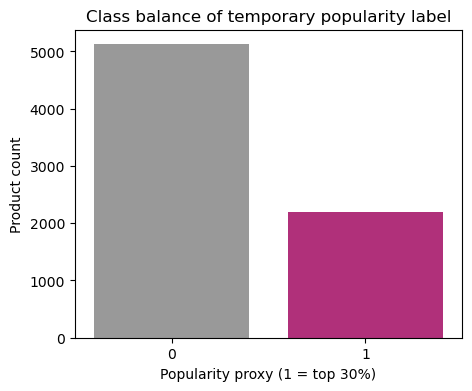

In [ ]:
plt.figure(figsize=(5, 4))
sns.countplot(x='popularity_proxy', data=df, palette=['#999999', '#c51b7d'])
plt.title('Class balance of temporary popularity label')
plt.xlabel('Popularity proxy (1 = top 30%)')
plt.ylabel('Product count')
plt.show()

## 3.2 Feature behavior vs popularity proxy

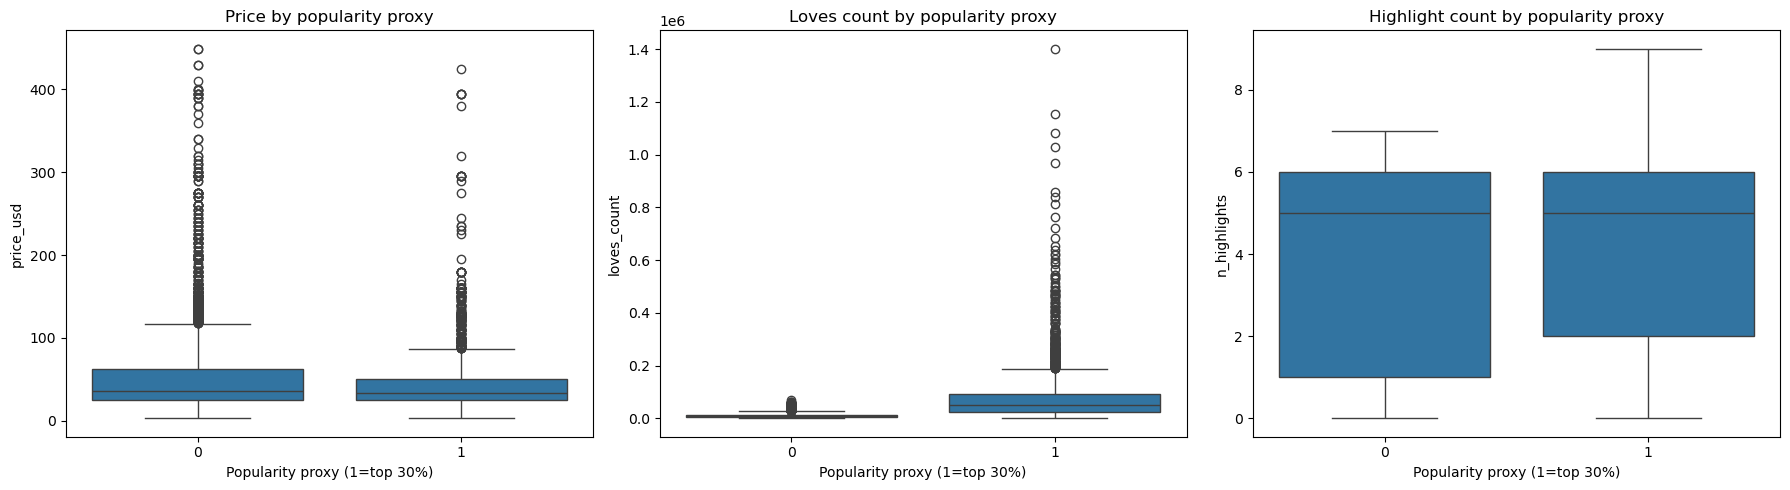

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(x='popularity_proxy', y='price_usd', data=df, ax=axes[0])
axes[0].set_title('Price by popularity proxy')
sns.boxplot(x='popularity_proxy', y='loves_count', data=df, ax=axes[1])
axes[1].set_title('Loves count by popularity proxy')
sns.boxplot(x='popularity_proxy', y='n_highlights', data=df, ax=axes[2])
axes[2].set_title('Highlight count by popularity proxy')
for ax in axes:
    ax.set_xlabel('Popularity proxy (1=top 30%)')
plt.tight_layout()
plt.show()

/var/folders/y7/21v74h5j5sn_fgcc5fd21wth0000gn/T/ipykernel_8389/3426141704.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


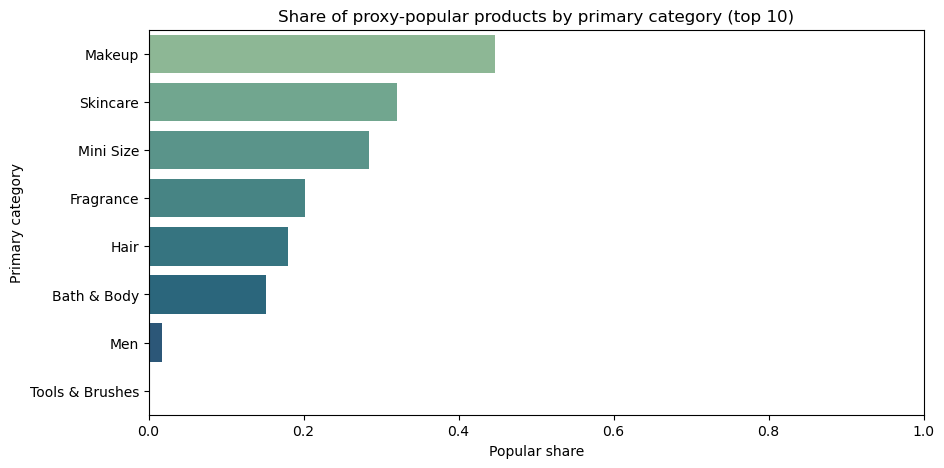

,popular_share,products
primary_category,,
Makeup,0.447224,1999
Skincare,0.321043,2224
Mini Size,0.284047,257
Fragrance,0.201518,1186
Hair,0.180195,1232
Bath & Body,0.151099,364
Men,0.017241,58
Tools & Brushes,0.000000,2


In [ ]:
popularity_by_category = (
    df.groupby('primary_category')['popularity_proxy']
      .agg(popular_share='mean', products='count')
      .sort_values('popular_share', ascending=False)
      .head(10)
)

plt.figure(figsize=(10, 5))
sns.barplot(
    y=popularity_by_category.index,
    x=popularity_by_category['popular_share'],
    palette='crest'
)
plt.title('Share of proxy-popular products by primary category (top 10)')
plt.xlabel('Popular share')
plt.ylabel('Primary category')
plt.xlim(0, 1)
plt.show()

popularity_by_category

## 3.3 Highlight & ingredient drivers

In [22]:
def canonicalize_tag(tag: str) -> str:
    return (
        "tag_"
        + tag.lower()
        .replace(" ", "_")
        .replace("/", "_")
        .replace(":", "")
        .replace(",", "")
        .replace("&", "and")
    )

try:
    hsel = pd.read_csv("highlight_features_selected.csv")
    highlight_cols = [canonicalize_tag(tag) for tag in hsel["tag"]]
    highlight_cols = [c for c in highlight_cols if c in df.columns]
except FileNotFoundError:
    highlight_cols = []

highlight_effect_df = pd.DataFrame()

if not highlight_cols:
    print("Highlight feature columns not found. Make sure the highlight dummy columns were created earlier in the notebook.")
else:
    highlight_effect = []
    for col in highlight_cols:
        means = df.groupby(col)["popularity_score"].mean()
        uplift = means.get(1, np.nan) - means.get(0, np.nan)
        highlight_effect.append({
            "feature": col,
            "share": df[col].mean().round(3),
            "avg_popularity_with_tag": means.get(1, np.nan),
            "uplift_vs_no_tag": uplift
        })
    highlight_effect_df = pd.DataFrame(highlight_effect).sort_values(
        "uplift_vs_no_tag", ascending=False
    ).head(10)

highlight_effect_df

Highlight feature columns not found. Make sure the highlight dummy columns were created earlier in the notebook.


""


In [ ]:
try:
    isel = pd.read_csv("ingredient_features_selected.csv", sep=";")
    ingredient_group_cols = [grp for grp in isel["group_name"].unique() if grp in df.columns]
except FileNotFoundError:
    ingredient_group_cols = []

ingredient_effect_df = pd.DataFrame()
if not ingredient_group_cols:
    print("Ingredient group columns not found. Ensure the ingredient feature engineering cell was executed.")
else:
    ingredient_effect = []
    for col in ingredient_group_cols:
        means = df.groupby(col)["popularity_score"].mean()
        uplift = means.get(1, np.nan) - means.get(0, np.nan)
        ingredient_effect.append({
            "group": col,
            "share": df[col].mean().round(3),
            "avg_popularity_with_group": means.get(1, np.nan),
            "uplift_vs_no_group": uplift
        })
    ingredient_effect_df = pd.DataFrame(ingredient_effect).sort_values(
        "uplift_vs_no_group", ascending=False
    ).head(10)

ingredient_effect_df

Ingredient group columns not found. Ensure the ingredient feature engineering cell was executed.


""


# 4. Study the popularity among other factors 


                  popularity_score  n_highlights  n_ingredients  brand_id
popularity_score          1.000000      0.055726      -0.023618 -0.059753
n_highlights              0.055726      1.000000       0.088142  0.311255
n_ingredients            -0.023618      0.088142       1.000000  0.027205
brand_id                 -0.059753      0.311255       0.027205  1.000000


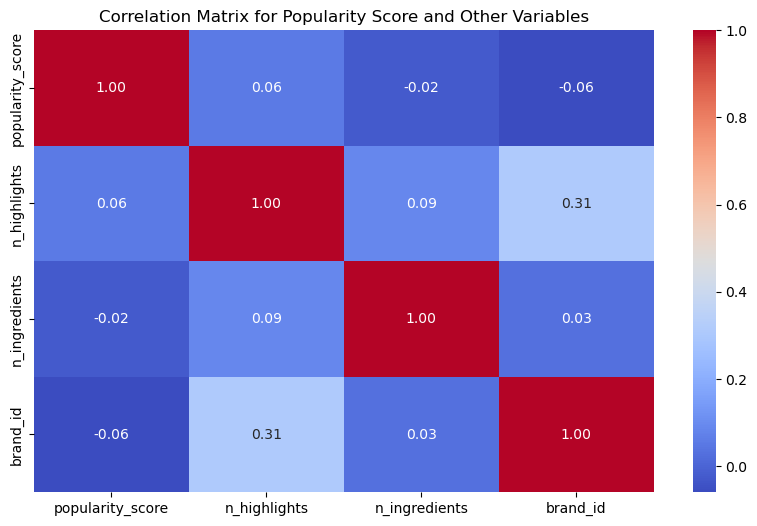

In [23]:
correlation_columns = ['popularity_score',  'n_highlights', 'n_ingredients', 'brand_id']


correlation_matrix = df[correlation_columns].corr()
print(correlation_matrix)


plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix for Popularity Score and Other Variables')
plt.show()


## 4.1 Popularity related to groups of ingredients, what type of combinations provide the higher popularity? 

We will use the itertools.combinations function to generate combinations of the ingredients and then calculate the average popularity score for each combination.

In [24]:
ingredient_columns = [col for col in df.columns if col.startswith('has_')]

# Function to calculate average popularity score for combinations of ingredients
def get_popularity_by_ingredients(df, ingredients_list):
   
    filtered_df = df.copy()
    for ingredient in ingredients_list:
        filtered_df = filtered_df[filtered_df[ingredient] == 1]
        avg_popularity = filtered_df['popularity_score'].mean() if len(filtered_df) > 0 else 0
    return avg_popularity

We will generate combinations of 2, 3 and 4 ingredients, calculate their average popularity score, and then sort them to see which type of grouping provides the highest popularity. This will help us decide how to handle ingredients when creating our model. 

In [25]:
combinations_2 = list(itertools.combinations(ingredient_columns, 2))
popularity_2 = []

for combo in combinations_2:
    avg_popularity = get_popularity_by_ingredients(df, combo)
    popularity_2.append((combo, avg_popularity))

popularity_2_sorted = sorted(popularity_2, key=lambda x: x[1], reverse=True)

print("Top 10 Combinations of 2 Ingredients:")
for combo, score in popularity_2_sorted[:10]:
    print(f"2 Ingredient Combination: {combo}, Average Popularity Score: {score}")


Top 10 Combinations of 2 Ingredients:
2 Ingredient Combination: ('has_chemical_sunscreen', 'has_mineral_sunscreen'), Average Popularity Score: 0.05954193548387096
2 Ingredient Combination: ('has_silicones', 'has_mineral_sunscreen'), Average Popularity Score: 0.03628477801268499
2 Ingredient Combination: ('has_mineral_sunscreen', 'has_common_preservatives'), Average Popularity Score: 0.03360766283524904
2 Ingredient Combination: ('has_humectants', 'has_mineral_sunscreen'), Average Popularity Score: 0.03264735792622134
2 Ingredient Combination: ('has_antioxidant_vitamins', 'has_mineral_sunscreen'), Average Popularity Score: 0.03183189189189189
2 Ingredient Combination: ('has_fragrance', 'has_mineral_sunscreen'), Average Popularity Score: 0.03177964376590331
2 Ingredient Combination: ('has_silicones', 'has_chemical_sunscreen'), Average Popularity Score: 0.02873642857142857
2 Ingredient Combination: ('has_emollient_oils', 'has_mineral_sunscreen'), Average Popularity Score: 0.02836710526315

In [26]:
combinations_3 = list(itertools.combinations(ingredient_columns, 3))
popularity_3 = []

for combo in combinations_3:
    avg_popularity = get_popularity_by_ingredients(df, combo)
    popularity_3.append((combo, avg_popularity))

popularity_3_sorted = sorted(popularity_3, key=lambda x: x[1], reverse=True)

print("Top 10 Combinations of 3 Ingredients:")
for combo, score in popularity_3_sorted[:10]:
    print(f"3 Ingredient Combination: {combo}, Average Popularity Score: {score}")


Top 10 Combinations of 3 Ingredients:
3 Ingredient Combination: ('has_silicones', 'has_chemical_sunscreen', 'has_mineral_sunscreen'), Average Popularity Score: 0.06808750000000001
3 Ingredient Combination: ('has_humectants', 'has_chemical_sunscreen', 'has_mineral_sunscreen'), Average Popularity Score: 0.06798695652173913
3 Ingredient Combination: ('has_chemical_sunscreen', 'has_mineral_sunscreen', 'has_common_preservatives'), Average Popularity Score: 0.05873703703703703
3 Ingredient Combination: ('has_drying_alcohols', 'has_chemical_sunscreen', 'has_mineral_sunscreen'), Average Popularity Score: 0.058225
3 Ingredient Combination: ('has_exfol_acids_bha', 'has_barrier_soothing', 'has_chemical_sunscreen'), Average Popularity Score: 0.053000000000000005
3 Ingredient Combination: ('has_emollient_oils', 'has_chemical_sunscreen', 'has_mineral_sunscreen'), Average Popularity Score: 0.04840666666666667
3 Ingredient Combination: ('has_silicones', 'has_mineral_sunscreen', 'has_common_preservativ

In [27]:
combinations_4 = list(itertools.combinations(ingredient_columns, 4))
popularity_4 = []

for combo in combinations_4:
    avg_popularity = get_popularity_by_ingredients(df, combo)
    popularity_4.append((combo, avg_popularity))

popularity_4_sorted = sorted(popularity_4, key=lambda x: x[1], reverse=True)

print("Top 10 Combinations of 4 Ingredients:")
for combo, score in popularity_4_sorted[:10]:
    print(f"4 Ingredient Combination: {combo}, Average Popularity Score: {score}")


Top 10 Combinations of 4 Ingredients:
4 Ingredient Combination: ('has_silicones', 'has_humectants', 'has_chemical_sunscreen', 'has_mineral_sunscreen'), Average Popularity Score: 0.07425238095238094
4 Ingredient Combination: ('has_drying_alcohols', 'has_silicones', 'has_chemical_sunscreen', 'has_mineral_sunscreen'), Average Popularity Score: 0.07113846153846153
4 Ingredient Combination: ('has_humectants', 'has_emollient_oils', 'has_chemical_sunscreen', 'has_mineral_sunscreen'), Average Popularity Score: 0.06995555555555555
4 Ingredient Combination: ('has_silicones', 'has_chemical_sunscreen', 'has_mineral_sunscreen', 'has_common_preservatives'), Average Popularity Score: 0.06854347826086955
4 Ingredient Combination: ('has_humectants', 'has_chemical_sunscreen', 'has_mineral_sunscreen', 'has_common_preservatives'), Average Popularity Score: 0.06845909090909091
4 Ingredient Combination: ('has_silicones', 'has_emollient_oils', 'has_chemical_sunscreen', 'has_mineral_sunscreen'), Average Popul

## 4.2 Popularity related to groups of highlights

In [28]:
highlight_columns = [col for col in df.columns if col.startswith('tag_')]

def get_popularity_by_highlights(df, highlights_list):
    filtered_df = df.copy()
    for highlight in highlights_list:
        filtered_df = filtered_df[filtered_df[highlight] == 1]
    
    avg_popularity = filtered_df['popularity_score'].mean() if len(filtered_df) > 0 else 0
    return avg_popularity


In [29]:
combinations_2_highlights = list(itertools.combinations(highlight_columns, 2))
popularity_2_highlights = []

for combo in combinations_2_highlights:
    avg_popularity = get_popularity_by_highlights(df, combo)
    popularity_2_highlights.append((combo, avg_popularity))

popularity_2_highlights_sorted = sorted(popularity_2_highlights, key=lambda x: x[1], reverse=True)

print("Top 10 Combinations of 2 Highlights:")
for combo, score in popularity_2_highlights_sorted[:10]:
    print(f"2 Highlights Combination: {combo}, Average Popularity Score: {score}")


Top 10 Combinations of 2 Highlights:
2 Highlights Combination: ('tag_good_for_dryness', 'tag_layerable_scent'), Average Popularity Score: 0.09645000000000001
2 Highlights Combination: ('tag_layerable_scent', 'tag_increases_shine'), Average Popularity Score: 0.09645000000000001
2 Highlights Combination: ('tag_long-wearing', 'tag_best_for_oily_combo_normal_skin'), Average Popularity Score: 0.09404571428571427
2 Highlights Combination: ('tag_good_for_pores', 'tag_natural_finish'), Average Popularity Score: 0.07997391304347826
2 Highlights Combination: ('tag_matte_finish', 'tag_best_for_oily_combo_normal_skin'), Average Popularity Score: 0.06578108108108109
2 Highlights Combination: ('tag_long-wearing', 'tag_without_phthalates'), Average Popularity Score: 0.06470740740740741
2 Highlights Combination: ('tag_long-wearing', 'tag_good_for_pores'), Average Popularity Score: 0.06390666666666668
2 Highlights Combination: ('tag_long-wearing', 'tag_matte_finish'), Average Popularity Score: 0.059713

In [30]:
combinations_3_highlights = list(itertools.combinations(highlight_columns, 3))
popularity_3_highlights = []

for combo in combinations_3_highlights:
    avg_popularity = get_popularity_by_highlights(df, combo)
    popularity_3_highlights.append((combo, avg_popularity))

popularity_3_highlights_sorted = sorted(popularity_3_highlights, key=lambda x: x[1], reverse=True)

print("Top 10 Combinations of 3 Highlights:")
for combo, score in popularity_3_highlights_sorted[:10]:
    print(f"3 Highlights Combination: {combo}, Average Popularity Score: {score}")


Top 10 Combinations of 3 Highlights:
3 Highlights Combination: ('tag_long-wearing', 'tag_matte_finish', 'tag_good_for_pores'), Average Popularity Score: 0.29095000000000004
3 Highlights Combination: ('tag_without_parabens', 'tag_good_for_pores', 'tag_natural_finish'), Average Popularity Score: 0.1892
3 Highlights Combination: ('tag_without_parabens', 'tag_hydrating', 'tag_vitamin_c'), Average Popularity Score: 0.1799166666666667
3 Highlights Combination: ('tag_vegan', 'tag_without_sulfates_sls_and_sles', 'tag_best_for_dry_combo_normal_skin'), Average Popularity Score: 0.15262
3 Highlights Combination: ('tag_long-wearing', 'tag_without_phthalates', 'tag_without_silicones'), Average Popularity Score: 0.1513
3 Highlights Combination: ('tag_cruelty-free', 'tag_good_for_pores', 'tag_natural_finish'), Average Popularity Score: 0.14626250000000002
3 Highlights Combination: ('tag_without_sulfates_sls_and_sles', 'tag_best_for_dry_combo_normal_skin', 'tag_best_for_oily_combo_normal_skin'), Avera

## 4.3 Going deeper, combining groups of ingredients with highlights 

Calculate average popularity score for combinations of ingredients and highlights

In [31]:
def get_popularity_by_ingredients_and_highlight(df, ingredients_list, highlight):
    filtered_df = df.copy()
    
    for ingredient in ingredients_list:
        filtered_df = filtered_df[filtered_df[ingredient] == 1]
    
    filtered_df = filtered_df[filtered_df[highlight] == 1]
    
    avg_popularity = filtered_df['popularity_score'].mean() if len(filtered_df) > 0 else 0
    return avg_popularity


In [32]:

combinations_3_ingredients_1_highlight = list(itertools.product(itertools.combinations(ingredient_columns, 3), highlight_columns))

popularity_3_ingredients_1_highlight = []

for combo in combinations_3_ingredients_1_highlight:
    ingredients_combo, highlight = combo
    avg_popularity = get_popularity_by_ingredients_and_highlight(df, ingredients_combo, highlight)
    popularity_3_ingredients_1_highlight.append(((ingredients_combo, highlight), avg_popularity))

popularity_3_ingredients_1_highlight_sorted = sorted(popularity_3_ingredients_1_highlight, key=lambda x: x[1], reverse=True)

print("Top 10 Combinations of 3 Ingredients + 1 Highlight:")
for combo, score in popularity_3_ingredients_1_highlight_sorted[:10]:
    print(f"Combination: {combo}, Average Popularity Score: {score}")



Top 10 Combinations of 3 Ingredients + 1 Highlight:
Combination: (('has_drying_alcohols', 'has_silicones', 'has_chemical_sunscreen'), 'tag_long-wearing'), Average Popularity Score: 0.29373333333333335
Combination: (('has_drying_alcohols', 'has_humectants', 'has_chemical_sunscreen'), 'tag_long-wearing'), Average Popularity Score: 0.29373333333333335
Combination: (('has_drying_alcohols', 'has_chemical_sunscreen', 'has_mineral_sunscreen'), 'tag_long-wearing'), Average Popularity Score: 0.29373333333333335
Combination: (('has_drying_alcohols', 'has_chemical_sunscreen', 'has_mineral_sunscreen'), 'tag_natural_finish'), Average Popularity Score: 0.29373333333333335
Combination: (('has_drying_alcohols', 'has_chemical_sunscreen', 'has_common_preservatives'), 'tag_long-wearing'), Average Popularity Score: 0.29373333333333335
Combination: (('has_humectants', 'has_chemical_sunscreen', 'has_mineral_sunscreen'), 'tag_long-wearing'), Average Popularity Score: 0.2309
Combination: (('has_chemical_sunsc

## 4.4 Brand and Popularity Interaction

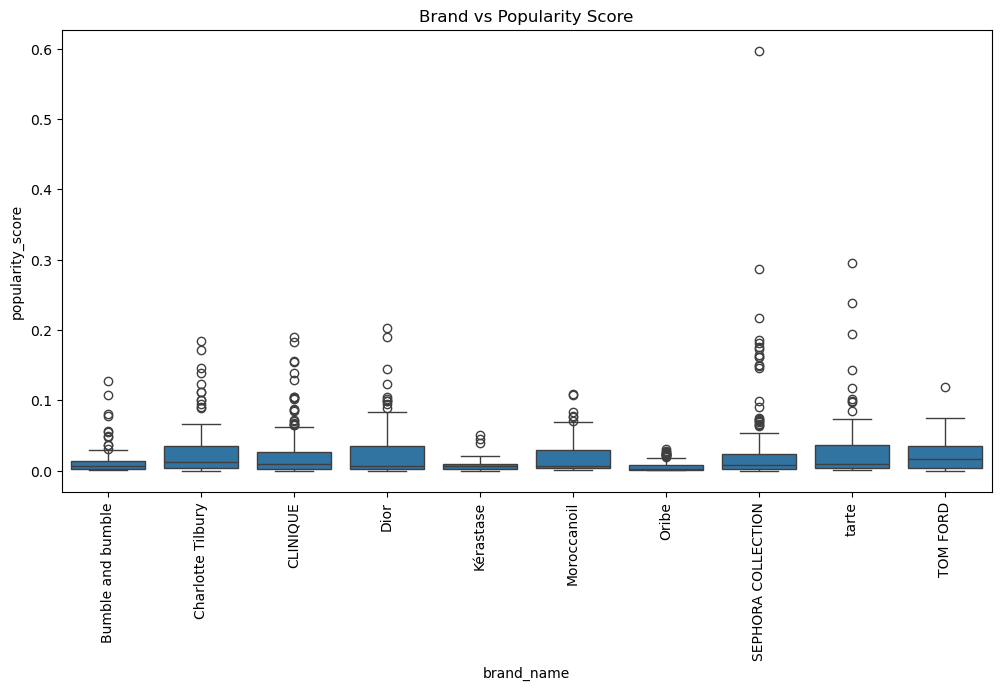

In [33]:
top_brands = df['brand_name'].value_counts().head(10).index
df_top_brands = df[df['brand_name'].isin(top_brands)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='brand_name', y='popularity_score', data=df_top_brands)
plt.xticks(rotation=90)
plt.title('Brand vs Popularity Score')
plt.show()


In [34]:

top_10_products = df.sort_values(by='popularity_score', ascending=False).head(10)
top_10_products[['product_name', 'popularity_score']]


,product_name,popularity_score
3745,Tattoo Liner Vegan Waterproof Liquid Eyeliner,0.8134
4644,Blush,0.8113
3915,Lip Sleeping Mask Intense Hydration with Vitam...,0.7760
2238,Pro Filt’r Soft Matte Longwear Liquid Foundation,0.7315
6881,24/7 Glide-On Waterproof Eyeliner Pencil,0.6926
6769,Better Than Sex Volumizing & Lengthening Mascara,0.6903
4643,Radiant Creamy Concealer,0.6829
2237,Gloss Bomb Universal Lip Luminizer,0.6325
5633,Cream Lip Stain Liquid Lipstick,0.5970
6771,Born This Way Natural Finish Longwear Liquid F...,0.5791


In [35]:

brand_popularity_median = df.groupby('brand_name')['popularity_score'].mean()

top_brands_median = brand_popularity_median.sort_values(ascending=False).head(10)
print(top_brands_median)


brand_name
Buxom                         0.157057
stila                         0.092690
Urban Decay                   0.082516
Rosebud Perfume Co.           0.080867
NARS                          0.079487
Olaplex                       0.076743
KVD Beauty                    0.076357
K18 Biomimetic Hairscience    0.072850
belif                         0.072808
Fenty Beauty by Rihanna       0.072523
Name: popularity_score, dtype: float64


In [36]:
df.to_csv("data/products_final.csv", index=False)

# 5. Prediction Model

Definition of a clean target variable for our model 


In [72]:
MODEL_DATA_PATH = "data/products_final.csv"
model_df = pd.read_csv(MODEL_DATA_PATH)

target_col = "popularity_proxy"
assert target_col in model_df.columns

print("Dataset shape:", model_df.shape)
print(model_df[target_col].value_counts(normalize=True))

Dataset shape: (7322, 83)
popularity_proxy
0    0.699809
1    0.300191
Name: proportion, dtype: float64


## 5.2 Feature selection & preprocessing plan
We remove:
    Leakage features (loves, reviews, rating, etc.) that would not exist before launch.
    Metadata/text fields not useful for modeling.

We keep only pre-launch predictors:
    Numeric features (price, n_ingredients, n_highlights…)
    Binary ingredient/highlight flags (has_*, tag_*)
    Categorical features (brand, primary category)

This ensures a fair model that can predict popularity for new products.

In [73]:
leakage_cols = [
    "loves_count","reviews","rating",
    "log_loves","log_reviews","reviews_per_love",
    "loves_count_norm","reviews_norm","scaled_rating_norm",
    "scaled_rating"
]

exclude_cols = {
    "product_id","product_name",
    "ingredients","ingredients_list","ingredients_text",
    "highlights","highlights_list","price_bucket",
    "popularity_score","popularity_proxy"
}

feature_candidates = [
    c for c in model_df.columns
    if c not in exclude_cols and c not in leakage_cols
]

numeric_features = [
    c for c in feature_candidates
    if (
        c in ["price_usd","child_count","n_ingredients","n_highlights"]
        or model_df[c].dtype in ("int64","float64")
    )
    and not c.startswith(("tag_","has_"))
]

binary_features = [
    c for c in feature_candidates
    if c.startswith("tag_") or c.startswith("has_")
]

categorical_features = ["brand_name", "primary_category"]

print("Numeric:", len(numeric_features))
print("Binary:", len(binary_features))
print("Categorical:", categorical_features)

Numeric: 10
Binary: 48
Categorical: ['brand_name', 'primary_category']


## 5.3 Train/test split and Gradient Boosting pipeline
We split the data into training and testing sets with stratification.
A preprocessing pipeline standardizes numeric features, imputes missing values, and one-hot encodes categorical fields.
We train a GradientBoostingClassifier, a strong non-linear model suitable for mixed feature types.

In [77]:
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

binary_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent"))
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features),
    ("bin", binary_pipeline, binary_features),
    ("cat", categorical_pipeline, categorical_features),
])

X = model_df[numeric_features + binary_features + categorical_features]
y = model_df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

gb_clf = GradientBoostingClassifier(random_state=42)

popularity_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", gb_clf)
])

popularity_model.fit(X_train, y_train)

print("Train accuracy:", popularity_model.score(X_train, y_train))
print("Test accuracy:", popularity_model.score(X_test, y_test))



Train accuracy: 0.807219512195122
Test accuracy: 0.7910787437414656


## 5.4 Evaluation on hold-out data
We evaluate performance on unseen data using accuracy, precision, recall, F1-score, ROC-AUC, and a confusion matrix.
This tells us how well the model can identify popular products using only pre-launch information.

In [78]:
y_pred = popularity_model.predict(X_test)
y_proba = popularity_model.predict_proba(X_test)[:,1]

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

print("ROC-AUC:", roc_auc_score(y_test, y_proba))

cm = confusion_matrix(y_test, y_pred)
display(pd.DataFrame(cm,
         index=["Actual 0","Actual 1"],
         columns=["Pred 0","Pred 1"]))


Classification report:
              precision    recall  f1-score   support

           0      0.801     0.933     0.862      1537
           1      0.747     0.461     0.570       660

    accuracy                          0.791      2197
   macro avg      0.774     0.697     0.716      2197
weighted avg      0.785     0.791     0.774      2197

ROC-AUC: 0.8577862226691114


,Pred 0,Pred 1
Actual 0,1434,103
Actual 1,356,304


## 5.5 Quick feature importance snapshot
Even without SHAP we can inspect the Gradient Boosting feature importances to see which engineered fields drive the proxy label the most.

In [79]:
preprocessor_step = popularity_model.named_steps["preprocess"]
model_step = popularity_model.named_steps["model"]

feature_names = preprocessor_step.get_feature_names_out()
importance_df = (
    pd.DataFrame({"feature": feature_names, "importance": model_step.feature_importances_})
    .sort_values("importance", ascending=False)
    .head(15)
)
importance_df

,feature,importance
7,num__child_count,0.346175
0,num__brand_id,0.122909
4,num__online_only,0.100551
1,num__price_usd,0.042793
2,num__limited_edition,0.022948
341,cat__primary_category_Skincare,0.021612
8,num__n_highlights,0.020241
9,num__n_ingredients,0.018368
336,cat__primary_category_Fragrance,0.017505
123,cat__brand_name_Drunk Elephant,0.015846


# 6. EXPLAINABILITY


Train SHAP Explainer & Compute SHAP Values. We initialize the SHAP and create a TreeExplained for the GradientBoostClassifier. We comput the shap_values for the X_test set. 

In [83]:
import shap
shap.initjs()

# Access trained model and preprocessor
model_step = popularity_model.named_steps["model"]
preprocess_step = popularity_model.named_steps["preprocess"]

# Transform train/test into final numeric arrays
X_train_transformed = preprocess_step.transform(X_train)
X_test_transformed  = preprocess_step.transform(X_test)

# Convert to dense numpy array (SHAP requires numeric matrix)
if hasattr(X_train_transformed, "toarray"):
    X_train_array = X_train_transformed.toarray()
    X_test_array  = X_test_transformed.toarray()
else:
    X_train_array = X_train_transformed
    X_test_array  = X_test_transformed

# Get feature names after transformation
feature_names = preprocess_step.get_feature_names_out()


In [84]:
explainer = shap.TreeExplainer(model_step)

# Compute SHAP values for the test set
shap_values = explainer(X_test_array)

print("SHAP values shape:", shap_values.values.shape)


SHAP values shape: (2197, 343)


# 6.1 Global Explainebility plots 

Shows the global influence of each feature on popularity predictions.

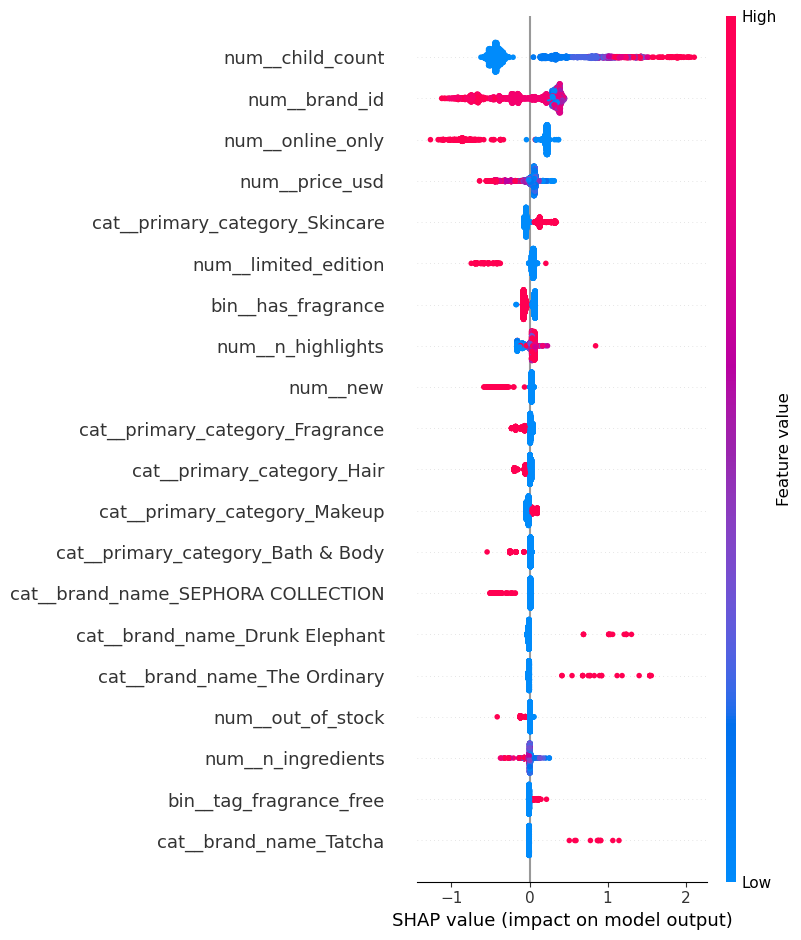

In [85]:
shap.summary_plot(shap_values.values, X_test_array, feature_names=feature_names)


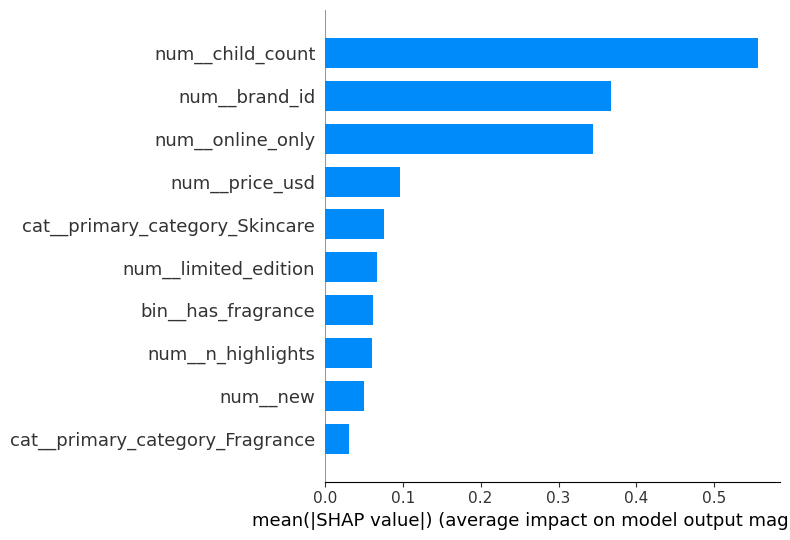

In [ ]:
shap.summary_plot(shap_values.values, X_test_transformed,
                  feature_names=feature_names,
                  plot_type="bar", max_display=10
                  
        )

# 6.2 Local explainability 

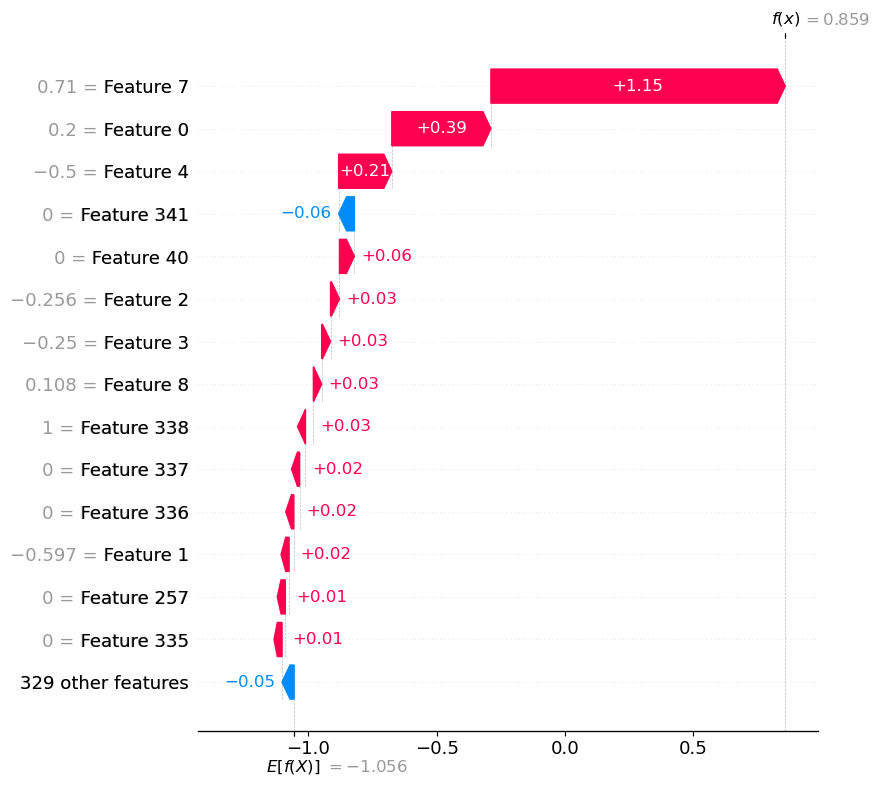

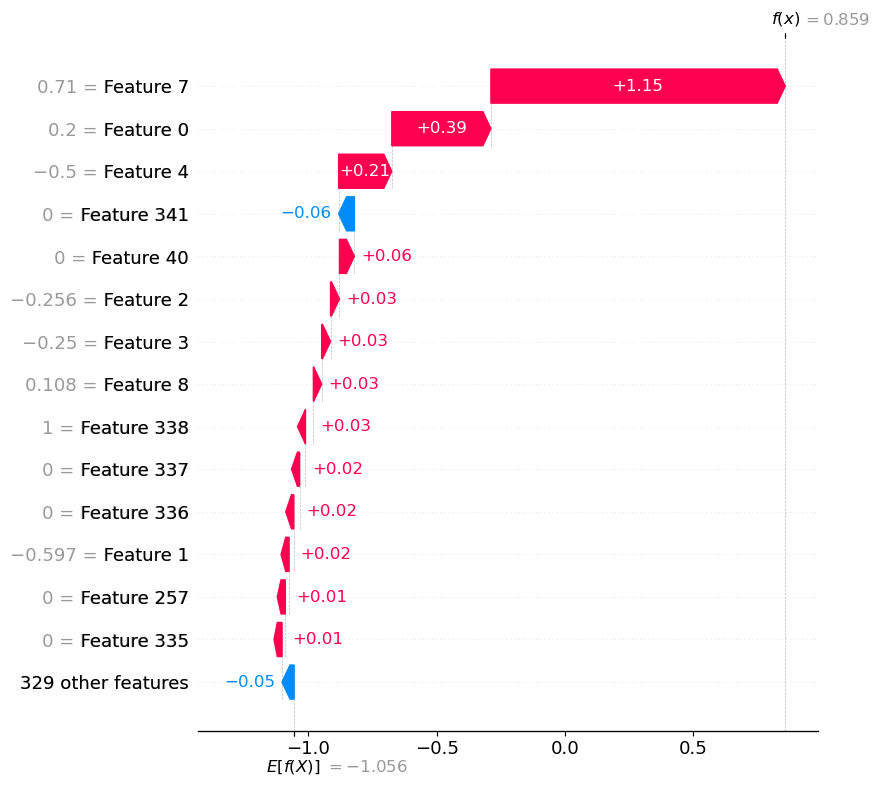

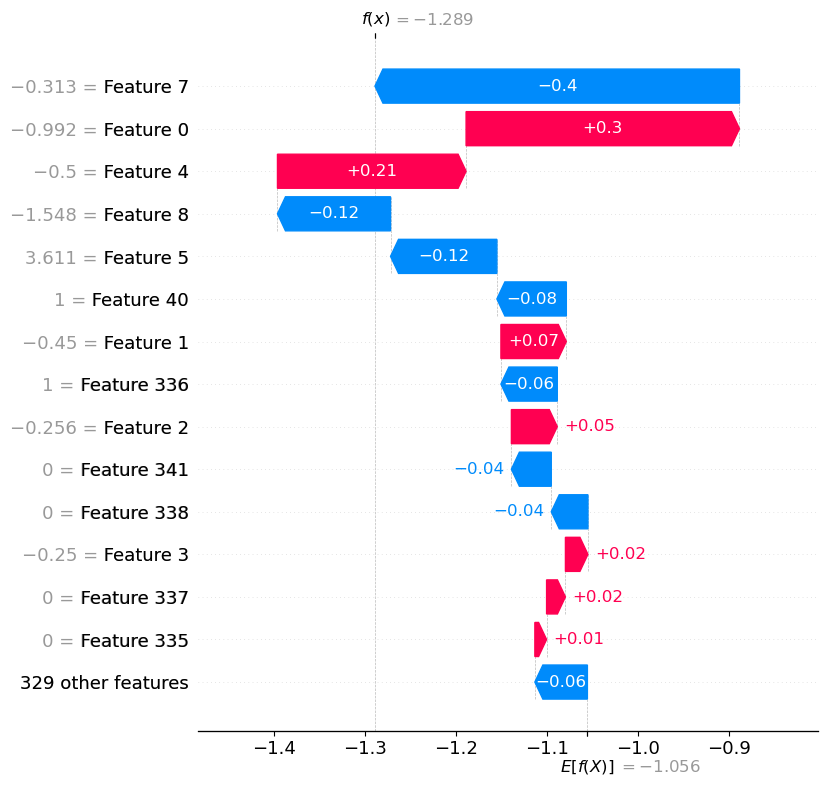

In [ ]:


# 1) Waterfall plot for a chosen index
i = 0   # choose any row in X_test 
shap.plots.waterfall(shap_values[i], max_display=15)



# 2) Waterfall plot for the first POPULAR product (proxy=1)

idx_popular = y_test[y_test == 1].index[0]         # get index label
pos_in_test = list(X_test.index).index(idx_popular)  # convert to positional index

shap.plots.waterfall(shap_values[pos_in_test], max_display=15)



# 3) Waterfall plot for the first UNPOPULAR product (proxy=0)

idx_unpopular = y_test[y_test == 0].index[0]
pos_in_test = list(X_test.index).index(idx_unpopular)

shap.plots.waterfall(shap_values[pos_in_test], max_display=15)



# 6.3 Filtering SHAP values by category

We will NOT retrain the model, we willl just compute SHAP for thw whole test set(as we have done ) and then filter by category. 

Also, some categories in the dataset have too few products in the test split to generate statistically meaningful SHAP interpretations.
SHAP requires a sufficient number of observations to estimate how each feature contributes to model predictions.
When a category has too few samples, the SHAP values become unstable, biased, and not interpretable, so we exclude them to preserve the reliability of insights.


===== SHAP for category: Fragrance =====



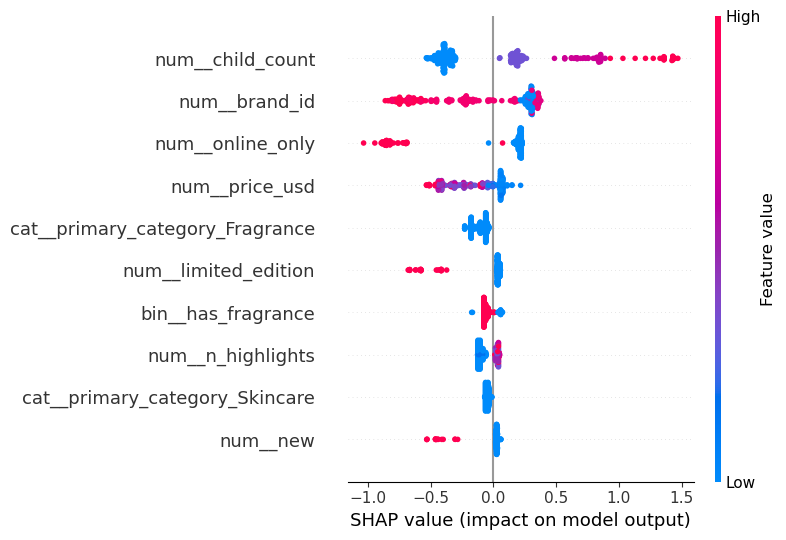


===== SHAP for category: Bath & Body =====



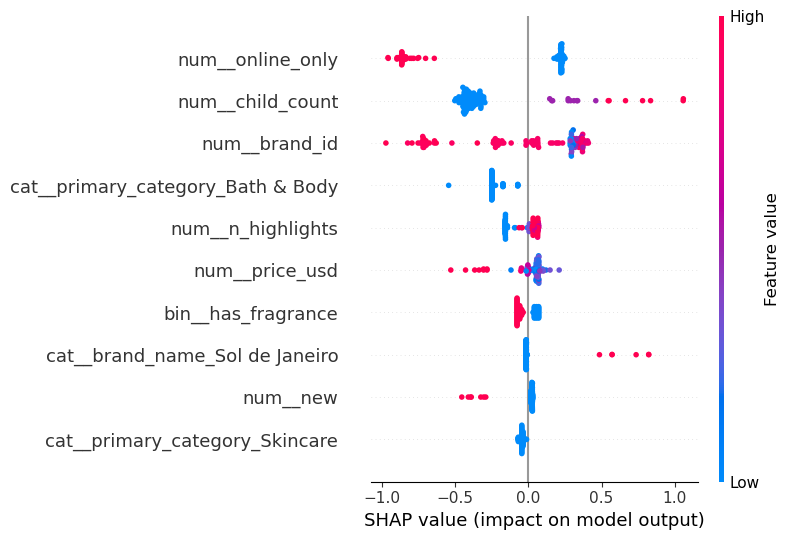


===== SHAP for category: Mini Size =====

Skipping Mini Size (only 71 samples)

===== SHAP for category: Hair =====



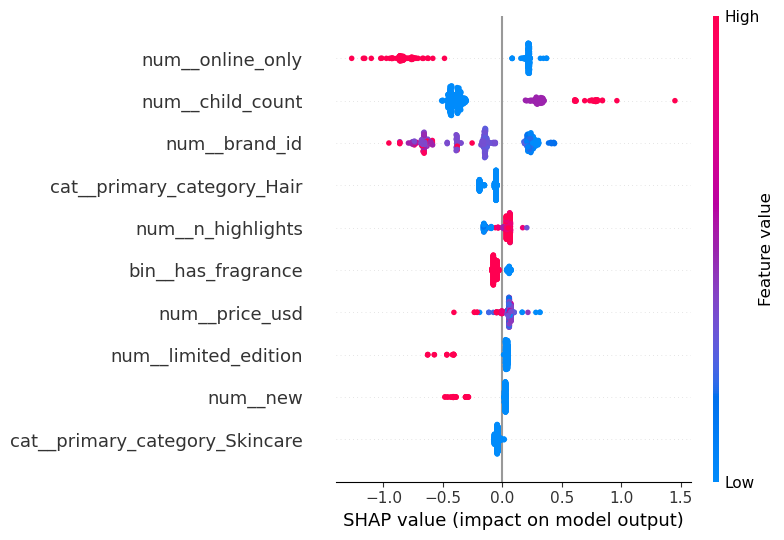


===== SHAP for category: Makeup =====



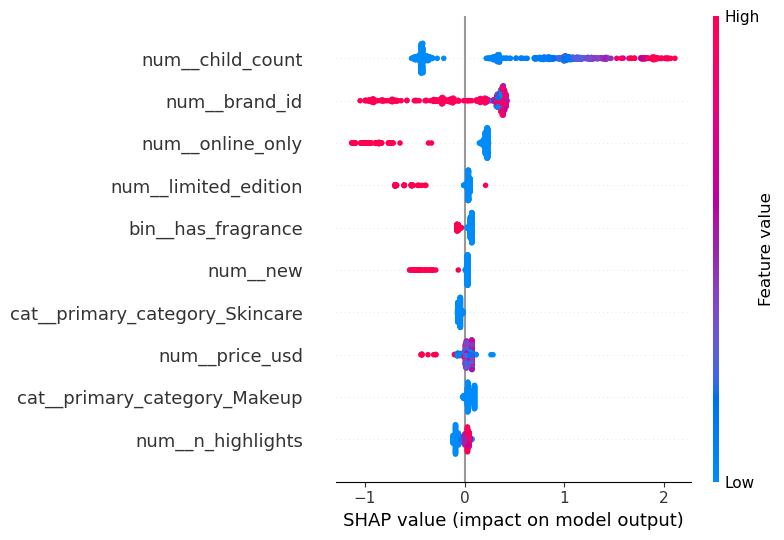


===== SHAP for category: Skincare =====



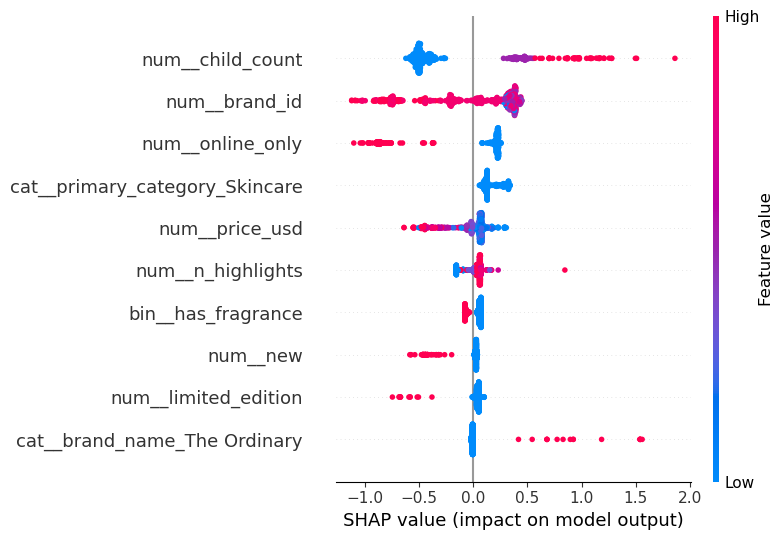


===== SHAP for category: Men =====

Skipping Men (only 15 samples)

===== SHAP for category: Tools & Brushes =====

Skipping Tools & Brushes (only 0 samples)


In [98]:
primary_cats = model_df["primary_category"].unique()

for cat in primary_cats:
    print(f"\n===== SHAP for category: {cat} =====\n")

    # mask rows in X_test that belong to this category
    mask = (model_df.loc[X_test.index, "primary_category"] == cat).values
    
    n = mask.sum()
    if n < 100:
        print(f"Skipping {cat} (only {n} samples)")
        continue

    # filtered SHAP summary plot
    shap.summary_plot(
        shap_values.values[mask],     # same shape subset
        X_test_array[mask],           # transformed numeric data subset
        feature_names=feature_names,
        max_display=10
    )


## 5.6 Next steps
- Validate stability with k-fold CV and/or alternative algorithms (Logistic Regression, XGBoost) to benchmark recall on the positive class.
- Persist `popularity_model` with `joblib` once satisfied, so the Streamlit app can load and score products consistently.
- Layer SHAP or permutation importance on top of this pipeline to surface richer explanations inside the dashboard.